In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%load_ext tensorboard

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [13]:
from PIL import Image
from IPython.display import display

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from build_model_classifier import build_model_classifier_1, build_model_classifier_2, build_model_classifier_3
from load_image import load_image
from get_frames import get_frames
from load_models import load_models
from get_labels import get_windows_original, get_windows_encoded, get_labels, get_defect_label
from assemble_image import assemble_image

from get_labels import get_defect_type
from prediction import predict_step, predict_image
from conf_matrix import get_accuracy, get_confusion_matrix, plot_confusion_matrix

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
#load data
stride_step = 50
unit_numb = 5
folder = 'classify_data'

file_name = f'save_data/{folder}/data_{stride_step}_{unit_numb}_6106.pkl'
with open(file_name, 'rb') as f:
    labels_all,windows_data_encoded_all = pickle.load(f)

In [8]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(
    windows_data_encoded_all, 
    labels_all, 
    test_size=test_size, 
    random_state=42
)

In [9]:
print(f'Original X shape: {windows_data_encoded_all.shape}')
print(f'Original y shape: {labels_all.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


Original X shape: (5313, 12, 5)
Original y shape: (5313,)
X_train shape: (4781, 12, 5)
y_train shape: (4781,)
X_test shape: (532, 12, 5)
y_test shape: (532,)


In [37]:
input_shape = windows_data_encoded_all.shape[1:]

settings_dict = {
    'input_shape':input_shape,
    'conv_blocks_list':[8,16],
    'dense_blocs_list':[100,100],
    'labels_nmb':4,
    'stride_step':stride_step,
    'unit_numb':unit_numb,
}

optimizer = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


model = model = build_model_classifier_3(settings_dict)
model.summary()
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 5)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 8)             128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 6, 8)              0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 16)             400       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 3, 16)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 48)                0   

In [38]:
batch_size = 2
epochs = 500
validation_split = 0.1
patience_lr = 2
patience_early_stop = 4

#Stop training when no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  patience=patience_early_stop, 
                                                  restore_best_weights=True)
#Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=patience_lr)
callbacks = [early_stopping, reduce_lr]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
)

Epoch 1/500
2151/2151 [==============================] - 6s 2ms/step - loss: 0.8036 - accuracy: 0.6511 - val_loss: 0.5489 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 2/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.4471 - accuracy: 0.8175 - val_loss: 0.4141 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 3/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.3500 - accuracy: 0.8629 - val_loss: 0.2863 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 4/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.2740 - accuracy: 0.8975 - val_loss: 0.5241 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 5/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.2298 - accuracy: 0.9149 - val_loss: 0.3409 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 6/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.2160 - accuracy: 0.9226 - val_loss: 0.1967 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 7/500
2151/2151 [=============================

Epoch 52/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0918 - val_accuracy: 0.9708 - lr: 1.0000e-04
Epoch 53/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0850 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 54/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0861 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 55/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.0858 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 56/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0849 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 57/500
2151/2151 [==============================] - 5s 2ms/step - loss: 0.0056 - accuracy: 0.9995 - val_loss: 0.0867 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 58/500
2151/2151

In [14]:
#save model and settings
settings_dict['batch_size'] = batch_size
settings_dict['validation_split'] = validation_split

#save settings to json
model_name = f'model_class_str_{stride_step}_un_{unit_numb}'

file_settings_name = f'{model_name}_settings.json'
folder = f'stride_{stride_step}/classify'  
model_path = f'saved_models/{folder}'
#create a folder if doesn't exist
os.makedirs(model_path, exist_ok=True)
with open(f'{model_path}/{file_settings_name}', 'w') as f:
    json.dump(settings_dict, f)

#save_model weights
model.save_weights(f'{model_path}/{model_name}/{model_name}') 

In [ ]:
#load model


In [28]:
#conv model
print(unit_numb)
train_loss, train_acc = model.evaluate(X_train,  y_train, verbose=2)
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTrain accuracy:', train_acc)
print('Test accuracy:', test_acc)

30
150/150 - 0s - loss: 0.0110 - accuracy: 0.9971 - 151ms/epoch - 1ms/step
17/17 - 0s - loss: 0.0634 - accuracy: 0.9850 - 30ms/epoch - 2ms/step

Train accuracy: 0.9970717430114746
Test accuracy: 0.9849624037742615


In [47]:
if 1:
    X = X_test
    y = y_test
else:
    X = X_train
    y = y_train


# Get probabilities
y_pred_probs = model.predict(X)  
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  
# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

17/17 [==============================] - 0s 859us/step


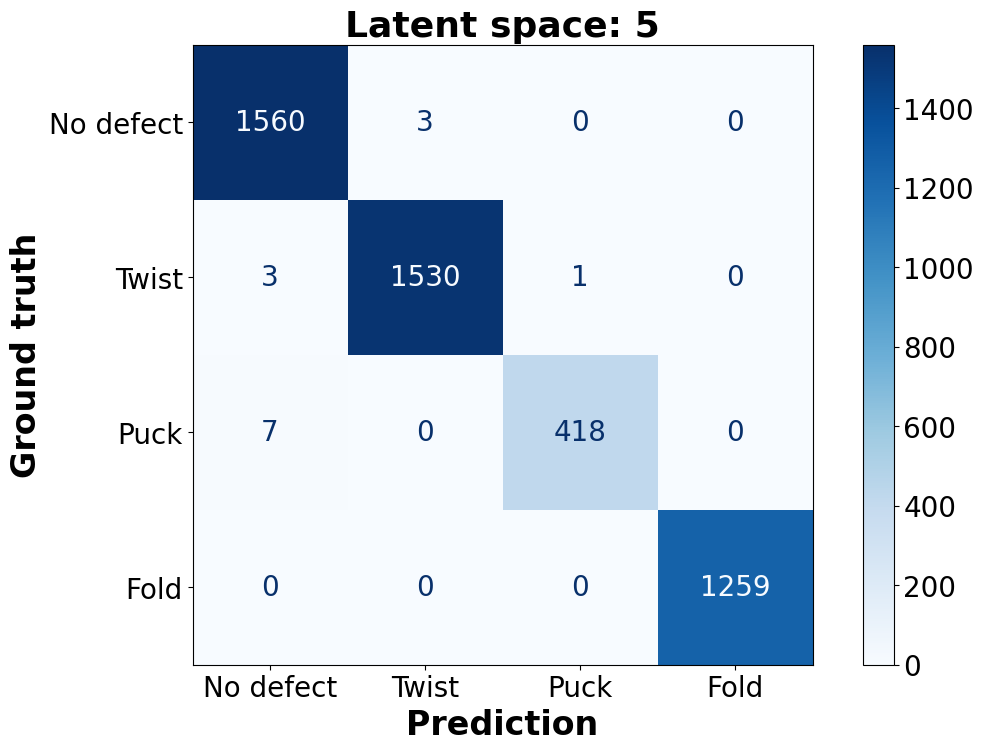

In [40]:
fontsize_sec = 14
fontsize_title = fontsize_sec+12
fontsize_label = fontsize_sec+6
fontsize_legend = fontsize_sec+6
fontsize_plot = fontsize_sec+6

fig, ax = plt.subplots(1,1, figsize=(10,10))

display_labels = [get_defect_type(x) for x in range(4)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)
for text_array in disp.text_:
    for text in text_array:
        text.set_fontsize(fontsize_plot)

ax.set_title(f'Latent space: {unit_numb}', fontsize=fontsize_title, fontweight='bold')
ax.tick_params(axis='both', labelsize=fontsize_label)
ax.set_xlabel('Prediction', fontsize=fontsize_label+4, fontweight='bold')
ax.set_ylabel('Ground truth', fontsize=fontsize_label+4, fontweight='bold')

cbar = ax.images[0].colorbar
cbar.ax.tick_params(labelsize=fontsize_legend)
coordinate_value = 0.05
cbar.ax.set_position([ax.get_position().x1 + coordinate_value, ax.get_position().y0, 
                      coordinate_value, ax.get_position().height])

save_folder = 'pictures/paper_pictures/stride_50/confusion'
filename = f'{save_folder}/{unit_numb}_train.svg'
plt.savefig(filename, bbox_inches='tight')

In [22]:
#manual confusion matrix assembly
stride_step = 50
unit_numb = 30

#load data image list
test_size = 0.1
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_test_all_str_50_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'

#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
del frames_data

if 1:
    image_list = [
        'Pucker26.png',
        'Twist22.png',
        'Twist23.png',
        'Fold22.png',
        'Pucker13.png',
        'Pucker3.png',
        'Twist10.png',
        'Pucker31.png',
        'Fold21.png',
        'Fold9.png',
    ]

#image list
print('Image list:')
print('\n'.join([f'{i}: {image}' for i, image in enumerate(image_list)]))

window_size = 6
window_size_predicted = 1
overlap = 0
repeat_prediction = 6
stateful = False
lstm_type = 'win'

lstm_pars_dict = {
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'repeat_prediction':repeat_prediction,
    'stateful':stateful,
    'lstm_type':lstm_type
}

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

#load labels
file_name = f'defects_borders.json'
folder = f'save_data/classify_data' 
with open(f'{folder}/{file_name}', 'r') as f:
    borders_dict = json.load(f)

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict, classifier=True, ifProbability=False)

y_pred_array = np.array([])
y_gt_array = np.array([])

for filename in image_list:
    image_data = load_image(filename)
    image_data_frames = get_frames(image_data, stride_step, ifPrint = False)
    window_size_total = window_size + (window_size_predicted-overlap)*repeat_prediction
    windows_data = get_windows_original(image_data_frames, stride_step, window_size_total, padding_dict)
    windows_data_encoded = get_windows_encoded(windows_data, models_dict['model_encoder'])
    
    #true labels
    defect_type = get_defect_label(filename)
    borders_list = borders_dict[filename]
    image_length = image_data.shape[1]
    
    labels_gt = get_labels(
        stride_step,
        borders_list, 
        image_length, 
        window_size_total, 
        defect_type
    )
    
    # Get probabilities
    y_pred_probs = models_dict['model_classifier'].predict(windows_data_encoded, verbose=0)  
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    y_pred_array = np.append(y_pred_array, y_pred)
    y_gt_array = np.append(y_gt_array, labels_gt)
    
    
    #break

Image list:
0: Pucker26.png
1: Twist22.png
2: Twist23.png
3: Fold22.png
4: Pucker13.png
5: Pucker3.png
6: Twist10.png
7: Pucker31.png
8: Fold21.png
9: Fold9.png


In [ ]:
cm = get_confusion_matrix(y_gt_array, y_pred_array)
print(f'LS:{unit_numb}. Accuracy {get_accuracy(cm)}')
cm_plot_options = {'plot_title':f'Latent space: {unit_numb}'}
cm_save_opt_dict = {
    'ifSave':False, 
    'path':'pictures/paper_pictures/stride_50/confusion', 
    'file_name':f'{unit_numb}_test.svg'
}
plot_confusion_matrix(cm, cm_plot_options, cm_save_opt_dict)

In [24]:
#get confusion matrix for prediction
#stride 50, frames_to_pred_total = 68
#stride 100, frames_to_pred_total = 34

#load models
stride_step = 50
unit_numb = 5

window_size = 6
window_size_predicted = 1
overlap = 0
lstm_type = 'win'
stateful = False
#how many frames to predict within a single step
repeat_prediction = 6
#how many steps
frames_to_pred_total = 69
verbose = 0
print(f'Stride: {stride_step}; predict: {window_size, window_size_predicted, overlap}; repeat_prediction: {repeat_prediction}; stateful: {stateful}')

image_list = [
    'Pucker26.png',
    'Twist22.png',
    'Twist23.png',
    'Fold22.png',
    'Pucker13.png',
    'Pucker3.png',
    'Twist10.png',
    'Pucker31.png',
    'Fold21.png',
    'Fold9.png',
]

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

lstm_pars_dict = {
    'stateful':stateful,
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'lstm_type':lstm_type,
}

#load labels
file_name = f'defects_borders.json'
folder = f'save_data/classify_data' 
with open(f'{folder}/{file_name}', 'r') as f:
    borders_dict = json.load(f)

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict, classifier=True, ifProbability=False)

y_pred_array = np.array([])
y_gt_array = np.array([])

window_size_total = window_size + (window_size_predicted-overlap)*repeat_prediction

for filename in image_list:
    print(filename)
    image_data_gt = load_image(filename)
    image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
    
    borders_list = borders_dict[filename]
    image_length = image_data_gt.shape[1]
    defect_type = get_defect_label(filename)
    predicted_data_dict = {}
    labels_dict = {}
    
    labels_gt = get_labels(
        stride_step,
        borders_list, 
        image_length, 
        #window_size_total//2, 
        window_size_total,
        defect_type
    )[:frames_to_pred_total]
    labels_dict['gt'] = labels_gt
    
    image_data_frames_list, image_data_frames_encoded = predict_image(
        image_data_frames_gt, 
        models_dict,
        lstm_pars_dict, 
        repeat_prediction,
        verbose=verbose,
        frames_to_pred_total=frames_to_pred_total
    )
    predicted_data_dict[unit_numb] = image_data_frames_list
    
    #classify
    #probabilities of defects for each frame
    try:
        probabilities = models_dict['model_classifier'].predict(np.array(image_data_frames_encoded), verbose=0)
        labels_predicted = np.argmax(probabilities, axis=1)
        labels_dict[unit_numb] = [labels_predicted, probabilities]
        
        y_pred_array = np.append(y_pred_array, labels_predicted)
        y_gt_array = np.append(y_gt_array, labels_gt)
    except KeyError:
        #if no classifier is available
        pass    

Stride: 50; predict: (6, 1, 0); repeat_prediction: 6; stateful: False
Pucker26.png
Twist22.png
Twist23.png
Fold22.png
Pucker13.png
Pucker3.png
Twist10.png
Pucker31.png
Fold21.png
Fold9.png


LS:5. Accuracy 0.8782608695652174


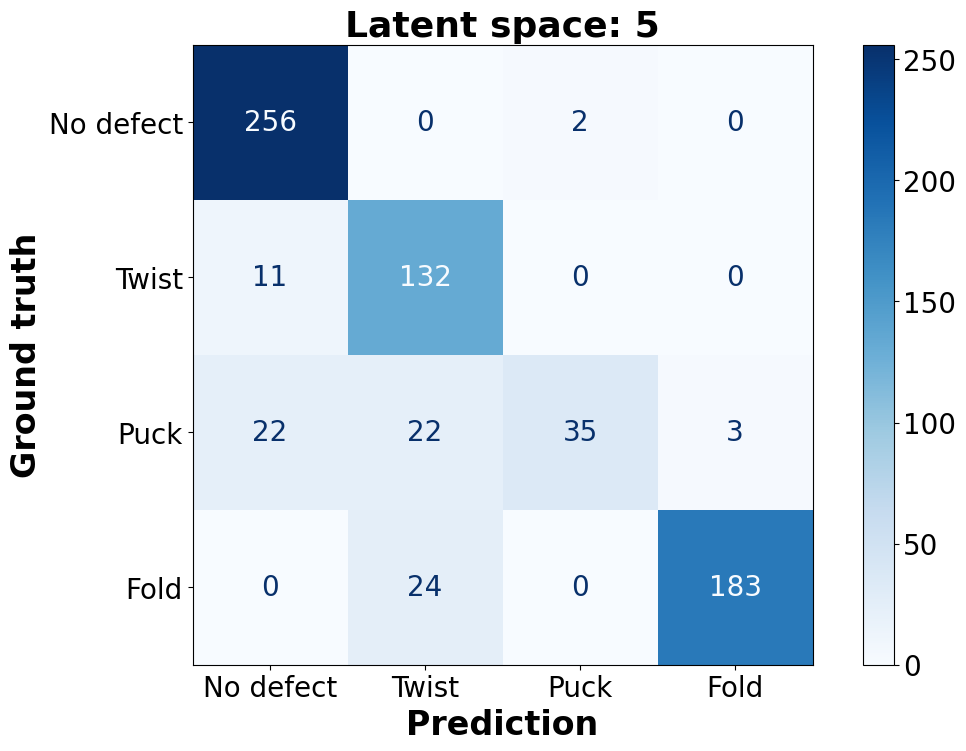

In [25]:
cm = get_confusion_matrix(y_gt_array, y_pred_array)
print(f'LS:{unit_numb}. Accuracy {get_accuracy(cm)}')
cm_plot_options = {'plot_title':f'Latent space: {unit_numb}'}
cm_save_opt_dict = {
    'ifSave':True, 
    'path':'pictures/paper_pictures/stride_50/confusion', 
    'file_name':f'pred_{unit_numb}_test.svg'
}
plot_confusion_matrix(cm, cm_plot_options, cm_save_opt_dict)